# Meagan Assignment: Cluster mapping for my own data set

In [2]:
%matplotlib inline

import warnings; warnings.simplefilter('ignore')

import pandas as pd
import os
from functools import reduce
import matplotlib.pyplot as plt
inline_rc = dict(plt.rcParams)
import numpy as np

from scipy.stats.stats import pearsonr
from scipy import stats
from scipy.stats import ks_2samp
from scipy.stats import entropy
from scipy.stats import norm
from scipy.stats import lognorm
from scipy.stats import nbinom
from scipy.stats.mstats import gmean
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import average
from scipy.cluster.hierarchy import dendrogram


import statsmodels.api as sm
lowess = sm.nonparametric.lowess
import math

import scipy.spatial.distance
from scipy.spatial.distance import *

import scipy.cluster

import sklearn
import sklearn.preprocessing

from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE

from matplotlib.colors import LinearSegmentedColormap

import seaborn as sns

from PIL import Image


from scipy import ndimage
from scipy import misc

In [16]:
#Import Kepler data

#pl_ columns dictate planet parameters, st_ columns are star parameters. Most distances in units of AU, planet size in relation to Jupiter

planetdf = pd.read_csv("Sheet 1-2019PlanetDataKepler.csv")

In [5]:
planetdf.columns

Index(['pl_hostname', 'pl_letter', 'pl_name', 'pl_discmethod',
       'pl_controvflag', 'pl_pnum', 'pl_orbper', 'pl_orbsmax', 'pl_orbeccen',
       'pl_orbincl', 'pl_bmassj', 'pl_bmassprov', 'pl_radj', 'pl_dens',
       'pl_ttvflag', 'pl_kepflag', 'pl_k2flag', 'pl_nnotes', 'ra_str', 'ra',
       'dec_str', 'dec', 'st_dist', 'st_optmag', 'st_optband', 'gaia_gmag',
       'st_teff', 'st_mass', 'st_rad', 'rowupdate', 'pl_facility'],
      dtype='object')

In [7]:
pldf=planetdf[['pl_name', 'pl_pnum', 'pl_orbper', 'pl_orbsmax', 'pl_orbeccen','pl_bmassj', 'st_dist','st_optmag','st_teff', 'st_mass', 'st_rad']]

#import columns that have values that can be compared between planets (not just notes or indexes)

(0.0001, 500)

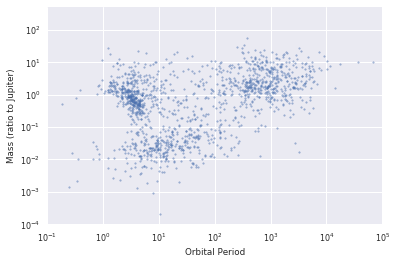

In [21]:
ax=plt.gca()
ax.scatter(pldf.pl_orbper, pldf.pl_bmassj, s=3, alpha=0.5)
plt.xlabel("Orbital Period")
plt.ylabel("Mass (ratio to Jupiter)")
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim(0.1, 100000)
ax.set_ylim(0.0001, 500)

The above values are way easier to see on log scales. 
To better compare values that vary over a wide range, take the log values of some parameters: 
    Log-scale: pl_orbper, pl_bmassj, pl_orbsmax, st_dist, st_teff, st_mass, st_rad

In [13]:
pldf_edit=planetdf[['pl_name', 'pl_pnum', 'pl_orbeccen','st_optmag']]
pldf_edit['pl_orbper_log']=np.log(pldf.pl_orbper) #add a new column called pl_orbper_log which takes the log values of everything in the pl_orbper column
pldf_edit['pl_bmassj_log']=np.log(pldf.pl_bmassj)
pldf_edit['pl_orbsmax_log']=np.log(pldf.pl_orbsmax)
pldf_edit['st_dist_log']=np.log(pldf.st_dist)
pldf_edit['st_teff_log']=np.log(pldf.st_teff)
pldf_edit['st_mass_log']=np.log(pldf.st_mass)
pldf_edit['st_rad_log']=np.log(pldf.st_rad)


In [14]:
pldf_edit.tail(10)

,pl_name,pl_pnum,pl_orbeccen,st_optmag,pl_orbper_log,pl_bmassj_log,pl_orbsmax_log,st_dist_log,st_teff_log,st_mass_log,st_rad_log
3906,tau Boo b,1,0.0110,4.500,1.197690,1.463255,-3.015935,2.751110,8.764053,0.292670,0.378436
3907,tau Cet e,4,0.1800,3.500,5.092952,-4.392481,-0.619897,1.280934,NaN,-0.248461,NaN
3908,tau Cet f,4,0.1600,3.500,6.455403,-4.392481,0.288182,1.280934,NaN,-0.248461,NaN
3909,tau Cet g,4,0.0600,3.500,2.995732,-5.201191,-2.017406,1.280934,NaN,-0.248461,NaN
3910,tau Cet h,4,0.2300,3.500,3.900153,-5.156818,-1.414694,1.280934,NaN,-0.248461,NaN
3911,tau Gem b,1,0.0310,4.420,5.721950,3.025291,0.157004,4.724197,8.386629,0.832909,3.288402
3912,ups And b,3,0.0215,4.100,1.529752,-0.374548,-2.826462,2.596001,NaN,0.262364,0.444686
3913,ups And c,3,0.2596,4.100,5.485867,0.683602,-0.189015,2.596001,NaN,0.262364,0.444686
3914,ups And d,3,0.2987,4.100,7.151846,1.418762,0.921593,2.596001,NaN,0.262364,0.444686
3915,xi Aql b,1,0.0000,4.707,4.918154,1.029619,-0.385662,4.030162,8.472196,0.788457,2.484907


In [17]:
pldf_edit_datacols = pldf_edit.columns.values[1:]
pldf_edit_plot=pldf_edit.set_index('pl_name').fillna(0)[pldf_edit_datacols]

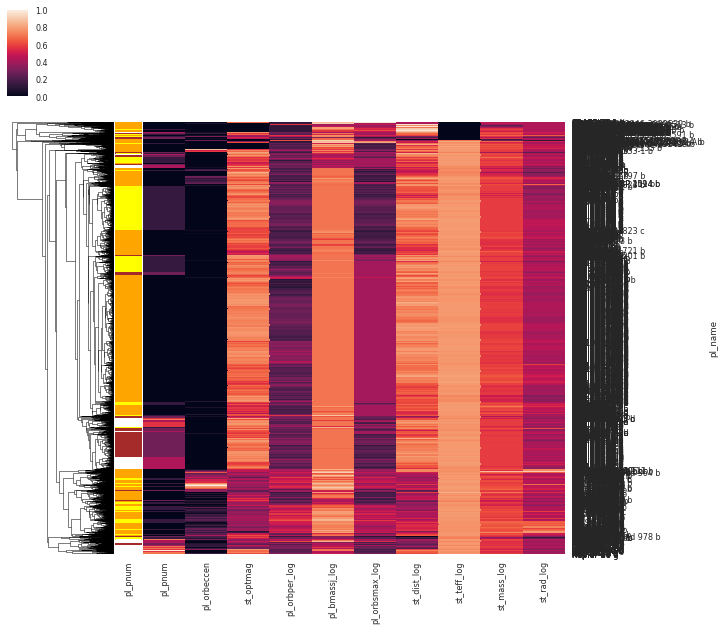

In [20]:
my_palette = dict(zip(pldf_edit_plot.pl_pnum.unique(), ["orange","yellow","brown"]))
row_colors = pldf_edit_plot.pl_pnum.map(my_palette)

#normalize values per column using standard_scale=1 and color clusters based on number of planets in system
sns.set(font_scale=0.8)
sns.clustermap(pldf_edit_plot, metric='euclidean', standard_scale=1, row_colors=row_colors, row_cluster = True, col_cluster = False, xticklabels=True, yticklabels=True)

